In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

In [3]:
import sklearn
sklearn.__version__

'0.20.1'

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [4]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train'), sample_n=8000)
X_test, y_test = read_data(get_dataset('valid'), sample_n=2000)
# X_train, y_train = read_data(get_dataset('train'), sample_n=100)
# X_test, y_test = read_data(get_dataset('valid'), sample_n=100)

2018-12-05 19:57:51,478 [INFO] Reading /opt/storage/train/sentiment_analysis_trainingset.csv.tokenized.csv..
2018-12-05 19:57:53,900 [INFO] Reading /opt/storage/train/sentiment_analysis_trainingset.csv..
2018-12-05 19:57:57,104 [INFO] Take 8000 samples with random state 1
2018-12-05 19:57:57,159 [INFO] Reading /opt/storage/valid/sentiment_analysis_validationset.csv.tokenized.csv..
2018-12-05 19:57:57,557 [INFO] Reading /opt/storage/valid/sentiment_analysis_validationset.csv..
2018-12-05 19:57:58,002 [INFO] Take 2000 samples with random state 1


In [8]:
# del fm['tfidf_sv']
# del fm['tfidf_sv_dense']
# del fm['lsa_200_sv']
# del fm['lsa_500_sv']
# del fm['count_tiny']

In [6]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [7]:
from fgclassifier.features import FeaturePipeline, logger

def build_features(fm_names, fm):
    for name in fm_names:
        logger.info(f'Building features for {name}...')
        model = FeaturePipeline.from_spec(name, cache=fm)
        model.fit_transform(X_train)
        model.transform(X_test)
    
build_features(['count', 'count_sv'], fm)

2018-12-05 19:58:20,860 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-05 19:58:20,925 [INFO] Building features for count...
2018-12-05 19:59:01,463 [INFO] Vocab Size: 4000
2018-12-05 19:59:03,579 [INFO] Building features for count_sv...
2018-12-05 19:59:43,640 [INFO] Vocab Size: 2000


Exam the quality of the top terms:

In [25]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count', 'count_sv']:
    model = fm[mn]['model'].named_steps[mn]
    key = next(filter(lambda x: 'fit_transform' in x, fm[mn].keys()))
    x_train = fm[mn][key]
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.3f, max_df: %.3f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    if model.stop_words_:
        print('\nStop words size: %s\n' % len(model.stop_words_))
    
    # Remove stop words as they take a lot of memory
    model.stop_words_ = {}
    
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:5]]))

Data Shape: (8000,) (2000,)

min_df: 5.000, max_df: 0.900, ngram_range: (1, 5)

vocab size: 4000

是 	 25167
很 	 21926
吃 	 18487
也 	 16800
！ 	 14847

min_df: 5.000, max_df: 0.600, ngram_range: (1, 5)

vocab size: 2000

！ 	 14847
我 	 11366
和 	 8712
感觉 	 6914
可以 	 6770


Save the word count features, as it is pretty slow to run for the whole dataset...

In [11]:
from sklearn.externals import joblib


def partial_get(d, keyword):
    key = next(filter(lambda x: x.startswith(keyword), d.keys()))
    return d[key]

def save_transform_cache(mn, path=None):
    path = path or f'data/fm_cache-{mn}'
    Xtrain = partial_get(fm[mn], 'fit_transform')
    Xtest = partial_get(fm[mn], 'transform')
    joblib.dump(Xtrain, path + '-train.pkl')
    joblib.dump(Xtest, path + '-test.pkl')
    print(f'Saved {path}')
    
save_transform_cache('count')
save_transform_cache('count_sv')
joblib.load('data/fm_cache-count-test.pkl')

Saved data/fm_cache-count
Saved data/fm_cache-count_sv


<2000x4000 sparse matrix of type '<class 'numpy.int64'>'
	with 280136 stored elements in Compressed Sparse Row format>

Build more features

In [12]:
build_features(['tfidf', 'tfidf_dense', 'lsa_500', 'lsa_1k'], fm)
build_features(['tfidf_sv', 'tfidf_sv_dense', 'lsa_500_sv', 'lsa_1k_sv'], fm)
# build_features(['tfidf_tiny', 'tfidf_tiny_dense', 'lsa_500_tiny'], fm)
build_features(['word2vec'], fm)

2018-12-05 20:00:33,385 [INFO] Building features for tfidf...
2018-12-05 20:00:33,386 [INFO]   count: fit_transform use cache.
2018-12-05 20:00:33,534 [INFO]   count: transform use cache.
2018-12-05 20:00:33,551 [INFO] Building features for tfidf_dense...
2018-12-05 20:00:33,555 [INFO]   tfidf: fit_transform use cache.
2018-12-05 20:00:33,808 [INFO]   tfidf: transform use cache.
2018-12-05 20:00:33,827 [INFO] Building features for lsa_500...
2018-12-05 20:00:33,828 [INFO]   tfidf: fit_transform use cache.
2018-12-05 20:00:40,160 [INFO]   tfidf: transform use cache.
2018-12-05 20:00:40,261 [INFO] Building features for lsa_1k...
2018-12-05 20:00:40,263 [INFO]   tfidf: fit_transform use cache.
2018-12-05 20:00:55,419 [INFO]   tfidf: transform use cache.
2018-12-05 20:00:55,775 [INFO] Building features for tfidf_sv...
2018-12-05 20:00:55,776 [INFO]   count_sv: fit_transform use cache.
2018-12-05 20:00:55,859 [INFO]   count_sv: transform use cache.
2018-12-05 20:00:55,866 [INFO] Building fe

2018-12-05 20:01:38,817 [INFO] EPOCH 9 - PROGRESS: at 27.44% examples, 393742 words/s, in_qsize 5, out_qsize 0
2018-12-05 20:01:39,839 [INFO] EPOCH 9 - PROGRESS: at 58.10% examples, 414103 words/s, in_qsize 6, out_qsize 1
2018-12-05 20:01:40,855 [INFO] EPOCH 9 - PROGRESS: at 87.84% examples, 417980 words/s, in_qsize 5, out_qsize 0
2018-12-05 20:01:41,275 [INFO] worker thread finished; awaiting finish of 2 more threads
2018-12-05 20:01:41,282 [INFO] worker thread finished; awaiting finish of 1 more threads
2018-12-05 20:01:41,292 [INFO] worker thread finished; awaiting finish of 0 more threads
2018-12-05 20:01:41,293 [INFO] EPOCH - 9 : training on 1516568 raw words (1448799 effective words) took 3.5s, 415922 effective words/s
2018-12-05 20:01:42,324 [INFO] EPOCH 10 - PROGRESS: at 26.79% examples, 376907 words/s, in_qsize 5, out_qsize 0
2018-12-05 20:01:43,374 [INFO] EPOCH 10 - PROGRESS: at 50.29% examples, 350005 words/s, in_qsize 5, out_qsize 0
2018-12-05 20:01:44,389 [INFO] EPOCH 10 -

In [13]:
save_transform_cache('tfidf')
save_transform_cache('lsa_500')
save_transform_cache('lsa_1k')

save_transform_cache('tfidf_sv')
save_transform_cache('lsa_500_sv')
save_transform_cache('lsa_1k_sv')

# save_transform_cache('tfidf_tiny')
# save_transform_cache('lsa_500_tiny')
# save_transform_cache('lsa_1k_tiny')

save_transform_cache('word2vec')

Saved data/fm_cache-tfidf
Saved data/fm_cache-lsa_500
Saved data/fm_cache-lsa_1k
Saved data/fm_cache-tfidf_sv
Saved data/fm_cache-lsa_500_sv
Saved data/fm_cache-lsa_1k_sv
Saved data/fm_cache-word2vec


## The Very Basic TF-IDF + LDA classifier

In [14]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline, Dummy
from fgclassifier.train import fm_cross_check

Check a basic model

In [15]:
model = Baseline('SGD_Logistic', fm=fm['lsa_1k']['model'])
# Always pass in the original features
# the pipeline will take care of the cache
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 20:02:10,261 [INFO]   lsa_1k: fit_transform use cache.
2018-12-05 20:02:22,325 [INFO]   lsa_1k: transform use cache.
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-05 20:02:22,498 [INFO]  F1 Score: 0.4513092203087992


lsa_1k_SGD_Logistic final score: 0.4513092203087992


Logistic is much slower but performs not much better than Stochastic logistic.

In [16]:
model = Baseline('SGD_Huber', fm=fm['lsa_1k']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 20:02:22,574 [INFO]   lsa_1k: fit_transform use cache.
2018-12-05 20:02:33,783 [INFO]   lsa_1k: transform use cache.
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-05 20:02:33,889 [INFO]  F1 Score: 0.4292292845957454


lsa_1k_SGD_Huber final score: 0.4292292845957454


In [17]:
model = Baseline('SGD_SVC', fm=fm['lsa_1k']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 20:02:33,946 [INFO]   lsa_1k: fit_transform use cache.
2018-12-05 20:02:43,060 [INFO]   lsa_1k: transform use cache.
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-05 20:02:43,165 [INFO]  F1 Score: 0.44607878729087547


lsa_1k_SGD_SVC final score: 0.44607878729087547


In [18]:
# model = Baseline('Ridge', fm=fm['lsa_1k']['model'])
# model.fit(X_train, y_train)
# print(f'{model.name} final score:', model.score(X_test, y_test))

## Search for the Best Feature + Classifier Combination

In [17]:
# Run for all classifiers and feature builders
train_avg_scores, train_scores = defaultdict(dict), defaultdict(dict)
test_avg_scores, test_scores = defaultdict(dict), defaultdict(dict)
test_time, train_time = defaultdict(dict), defaultdict(dict)

In [18]:
from fgclassifier import classifiers
from fgclassifier.baseline import Dummy

Dummy(classifiers.DummyStratified)

Dummy(classifier=None)

In [19]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'test': test_scores,
        'test_time': test_time,
        'test_avg': test_avg_scores,
        'train': train_scores,
        'train_time': train_time,
        'train_avg': train_avg_scores
    }
}

In [20]:
from IPython.display import clear_output

# # We'd only need to run the dummy models on one feature model,
# # as they do not care about the features
fm_cross_check(
    ['count', 'count_sv',
     'tfidf', 'tfidf_sv'],
    ['DummyStratified', 'DummyMostFrequent'],
    model_cls=Dummy, **conf)

# # Naive Bayes models cannot handle negative values, so we pass
# # in only tfidf features
fm_cross_check(
    ['count', 'count_sv',
     'tfidf', 'tfidf_sv'],
    ['ComplementNB'], **conf)
clear_output()

In [21]:
# Only SGD methods can handle sparse matrix
fm_cross_check(
    [
     'tfidf', 'lsa_500', 'lsa_1k',
     'tfidf_sv', 'lsa_500_sv', 'lsa_1k_sv',
     'count', 'count_sv',
    ],
    ['SGD_Logistic', 'SGD_SVC'], **conf)

clear_output()

In [22]:
# All other models can run on many classifiers
results = fm_cross_check(
    ['lsa_500', 'lsa_1k',
     'lsa_500_sv', 'lsa_1k_sv'],
    ['LDA', 'Ridge'], **conf)

clear_output()

In [23]:
results = fm_cross_check(
    ['word2vec'],
    ['SGD_Logistic', 'SGD_SVC', 'LDA', 'Ridge'], **conf)

2018-12-05 15:09:48,795 [INFO] 
2018-12-05 15:09:48,797 [INFO] ============ Feature Model: word2vec ============
2018-12-05 15:09:48,798 [INFO] 
2018-12-05 15:09:48,799 [INFO] Train for word2vec -> SGD_Logistic...
2018-12-05 15:09:48,801 [INFO]   word2vec: fit_transform use cache.
2018-12-05 15:10:39,005 [INFO]   word2vec: transform use cache.
2018-12-05 15:10:39,116 [INFO] -------------------------------------------------------
2018-12-05 15:10:39,117 [INFO] 【word2vec -> SGD_Logistic】 Train: 0.3883, Test: 0.3679
2018-12-05 15:10:39,118 [INFO] -------------------------------------------------------
2018-12-05 15:10:39,120 [INFO] Train for word2vec -> SGD_SVC...
2018-12-05 15:10:39,122 [INFO]   word2vec: fit_transform use cache.
2018-12-05 15:10:48,518 [INFO]   word2vec: transform use cache.
2018-12-05 15:10:49,431 [INFO]   word2vec: transform use cache.
2018-12-05 15:10:49,543 [INFO] -------------------------------------------------------
2018-12-05 15:10:49,544 [INFO] 【word2vec -> SGD

In [24]:
results = fm_cross_check(
    ['tfidf_sv_dense'],
    ['LDA', 'Ridge'], **conf)

2018-12-05 15:11:54,029 [INFO] 
2018-12-05 15:11:54,031 [INFO] ============ Feature Model: tfidf_sv_dense ============
2018-12-05 15:11:54,032 [INFO] 
2018-12-05 15:11:54,033 [INFO] Train for tfidf_sv_dense -> LDA...
2018-12-05 15:11:54,035 [INFO]   tfidf_sv_dense: fit_transform use cache.
2018-12-05 15:19:07,144 [INFO]   tfidf_sv: transform use cache.
2018-12-05 15:19:09,702 [INFO]   tfidf_sv_dense: transform use cache.
2018-12-05 15:19:09,949 [INFO] -------------------------------------------------------
2018-12-05 15:19:09,950 [INFO] 【tfidf_sv_dense -> LDA】 Train: 0.6955, Test: 0.5064
2018-12-05 15:19:09,951 [INFO] -------------------------------------------------------
2018-12-05 15:19:09,952 [INFO] Train for tfidf_sv_dense -> Ridge...
2018-12-05 15:19:09,955 [INFO]   tfidf_sv_dense: fit_transform use cache.
2018-12-05 15:27:07,368 [INFO]   tfidf_sv_dense: transform use cache.
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetri

In [26]:
# This is very slow ...
# results = fm_cross_check(
#     ['tfidf_dense'],
#     ['LDA', 'Ridge'], **conf)

In [23]:
# Boosting is too damn slow...
# results = fm_cross_check(
#     ['lsa_500',
#      'lsa_500_sv',
#      'lsa_500_tiny',
#      'lsa_1k',
#      'word2vec',
#     ],
#     ['XGB', 'AdaBoost', 'GradientBoost'], **conf)
# clear_output()

In [27]:
def merge_dense(obj):
    obj = obj.copy()
    obj['tfidf'] = {
        **obj['tfidf_dense'],
        **obj['tfidf']
    }
    obj['tfidf_sv'] = {
        **obj['tfidf_sv_dense'],
        **obj['tfidf_sv']
    }
    del obj['tfidf_dense']
    del obj['tfidf_sv_dense']
    return obj

def extract_scores(scores, avg_scores):
    scores = merge_dense(scores)
    avg_scores = merge_dense(avg_scores)
    rows = {}
    for fm_name in scores:
        for clf_name in avg_scores[fm_name]:
            key = f'{fm_name}.{clf_name}'
            rows[key] = [avg_scores[fm_name][clf_name], *scores[fm_name][clf_name]]
    df = pd.DataFrame(rows)
    df.index = ['average', *y_train.columns]
    return df.T.sort_values('average', ascending=False)

df_train = extract_scores(train_scores, train_avg_scores)
df_test = extract_scores(test_scores, test_avg_scores)
df_test

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
tfidf.SGD_SVC,0.515722,0.465143,0.381500,0.508840,0.453651,0.608989,0.550764,0.520986,0.572563,0.530942,...,0.509467,0.578942,0.532222,0.521403,0.512191,0.550419,0.424464,0.513239,0.482071,0.527034
tfidf_sv.LDA,0.506440,0.461021,0.366454,0.507935,0.481038,0.608153,0.477760,0.534823,0.536018,0.538934,...,0.525303,0.479481,0.508597,0.505075,0.506164,0.539023,0.419594,0.552063,0.510187,0.535834
tfidf.SGD_Logistic,0.506034,0.450884,0.382817,0.492408,0.459845,0.609708,0.463425,0.511368,0.552670,0.502685,...,0.546761,0.561682,0.540027,0.501290,0.511047,0.568589,0.435573,0.462872,0.505637,0.530378
tfidf_sv.SGD_SVC,0.504687,0.458605,0.366261,0.513627,0.486907,0.603693,0.434304,0.524159,0.549539,0.547968,...,0.510218,0.488928,0.515961,0.504081,0.506228,0.548699,0.429676,0.538485,0.475865,0.541728
lsa_1k.LDA,0.502776,0.420711,0.346745,0.494788,0.489338,0.628424,0.496933,0.516887,0.534340,0.512925,...,0.531892,0.512944,0.508466,0.501918,0.497358,0.562532,0.402093,0.507431,0.511930,0.523103
tfidf_sv.SGD_Logistic,0.501666,0.480390,0.368274,0.491381,0.466948,0.616872,0.469788,0.521302,0.534322,0.484315,...,0.505315,0.502736,0.512574,0.512905,0.507611,0.550776,0.417609,0.518676,0.497600,0.535176
lsa_1k_sv.LDA,0.500822,0.423775,0.381151,0.497873,0.468511,0.620572,0.485129,0.511003,0.513555,0.494066,...,0.508921,0.496485,0.488246,0.498441,0.503987,0.554654,0.406877,0.551495,0.502698,0.544133
lsa_1k.SGD_SVC,0.491048,0.401981,0.378384,0.485502,0.464934,0.602486,0.499261,0.506174,0.531015,0.501664,...,0.494435,0.502299,0.494461,0.494424,0.503404,0.556709,0.422808,0.464186,0.467226,0.525661
lsa_1k_sv.SGD_SVC,0.486052,0.456659,0.358554,0.488488,0.483543,0.617761,0.465570,0.513185,0.522682,0.488180,...,0.532235,0.404614,0.477559,0.521686,0.488216,0.486791,0.409844,0.484815,0.467899,0.511298
lsa_1k_sv.SGD_Logistic,0.485917,0.438668,0.355334,0.472156,0.431259,0.626889,0.482261,0.529648,0.508086,0.453262,...,0.516442,0.472002,0.479115,0.491855,0.501754,0.562902,0.372584,0.464626,0.505303,0.518340


In [28]:
# Save the results
results = conf['results'].copy()
del results['models']  # don't save models (which are huuuuge)
joblib.dump(results, 'data/model-selection-zh.pkl')

['data/model-selection-zh.pkl']

In [29]:
# important columns
imp_cols = ['count', 'count_sv', 'tfidf', 'tfidf_sv', 'lsa_500', 'lsa_500_sv', 'lsa_1k', 'lsa_1k_sv', 'word2vec']

def extract_avg_scores(scores):
    scores = merge_dense(scores)
    df = pd.DataFrame(scores)
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df = df.sort_values(by='avg', axis=1, ascending=False)
    df = df.sort_values(by='avg', ascending=False)
    df = df.drop(['avg'], axis=1)
    df = df.drop(['avg'], axis=0)
    return df[imp_cols]

df_train_avg = extract_avg_scores(train_avg_scores)
df_test_avg = extract_avg_scores(test_avg_scores)
df_test_avg

,count,count_sv,tfidf,tfidf_sv,lsa_500,lsa_500_sv,lsa_1k,lsa_1k_sv,word2vec
LDA,NaN,NaN,NaN,0.506440,0.478967,0.471317,0.502776,0.500822,0.442720
SGD_SVC,0.449736,0.426823,0.515722,0.504687,0.456939,0.453108,0.491048,0.486052,0.375649
SGD_Logistic,0.452966,0.413190,0.506034,0.501666,0.462204,0.468501,0.480589,0.485917,0.367950
ComplementNB,0.417039,0.403941,0.424446,0.410295,NaN,NaN,NaN,NaN,NaN
Ridge,NaN,NaN,NaN,0.403530,0.383646,0.379584,0.398656,0.389675,0.361532
DummyStratified,0.251690,0.249628,0.246643,0.253652,NaN,NaN,NaN,NaN,NaN
DummyMostFrequent,0.199658,0.199658,0.199658,0.199658,NaN,NaN,NaN,NaN,NaN


In [30]:
def extract_running_time(times):
    df = pd.DataFrame(times)
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df = df.sort_values(by='avg', axis=1, ascending=True)
    df = df.sort_values(by='avg', ascending=True)
    df = df.drop(['avg'], axis=1)
    df = df.drop(['avg'], axis=0)
    return df[imp_cols]
    
df_train_time = extract_running_time(train_time)
df_test_time = extract_running_time(test_time)
df_train_time

,count,count_sv,tfidf,tfidf_sv,lsa_500,lsa_500_sv,lsa_1k,lsa_1k_sv,word2vec
DummyMostFrequent,0.119035,0.109002,0.110012,0.117998,NaN,NaN,NaN,NaN,NaN
DummyStratified,0.153997,0.144034,0.145048,0.149046,NaN,NaN,NaN,NaN,NaN
ComplementNB,16.786956,16.263034,0.822029,0.703039,NaN,NaN,NaN,NaN,NaN
SGD_SVC,8.607989,6.416916,6.127026,5.329024,14.006461,13.594027,23.839003,24.029966,10.311456
SGD_Logistic,9.347991,7.199997,6.920030,6.105377,14.703990,16.915040,30.188998,28.448752,50.205629
LDA,NaN,NaN,NaN,NaN,54.869002,51.870993,144.114567,135.675885,29.252680
Ridge,NaN,NaN,NaN,NaN,64.896123,62.816861,156.408434,154.385015,34.818027


In [31]:
df_test_time

,count,count_sv,tfidf,tfidf_sv,lsa_500,lsa_500_sv,lsa_1k,lsa_1k_sv,word2vec
DummyMostFrequent,0.017005,0.016993,0.016951,0.017054,NaN,NaN,NaN,NaN,NaN
DummyStratified,0.019042,0.018997,0.018984,0.019999,NaN,NaN,NaN,NaN,NaN
ComplementNB,0.065000,0.049971,0.042001,0.036998,NaN,NaN,NaN,NaN,NaN
SGD_Logistic,0.080041,0.065043,0.041009,0.043003,0.069041,0.084001,0.142035,0.136972,0.110991
SGD_SVC,0.073028,0.062005,0.044029,0.047004,0.106990,0.090001,0.136041,0.147037,0.112011
Ridge,NaN,NaN,NaN,NaN,0.103997,0.089000,0.148002,0.145003,0.106969
LDA,NaN,NaN,NaN,NaN,0.088000,0.085045,0.145001,0.134999,0.118991


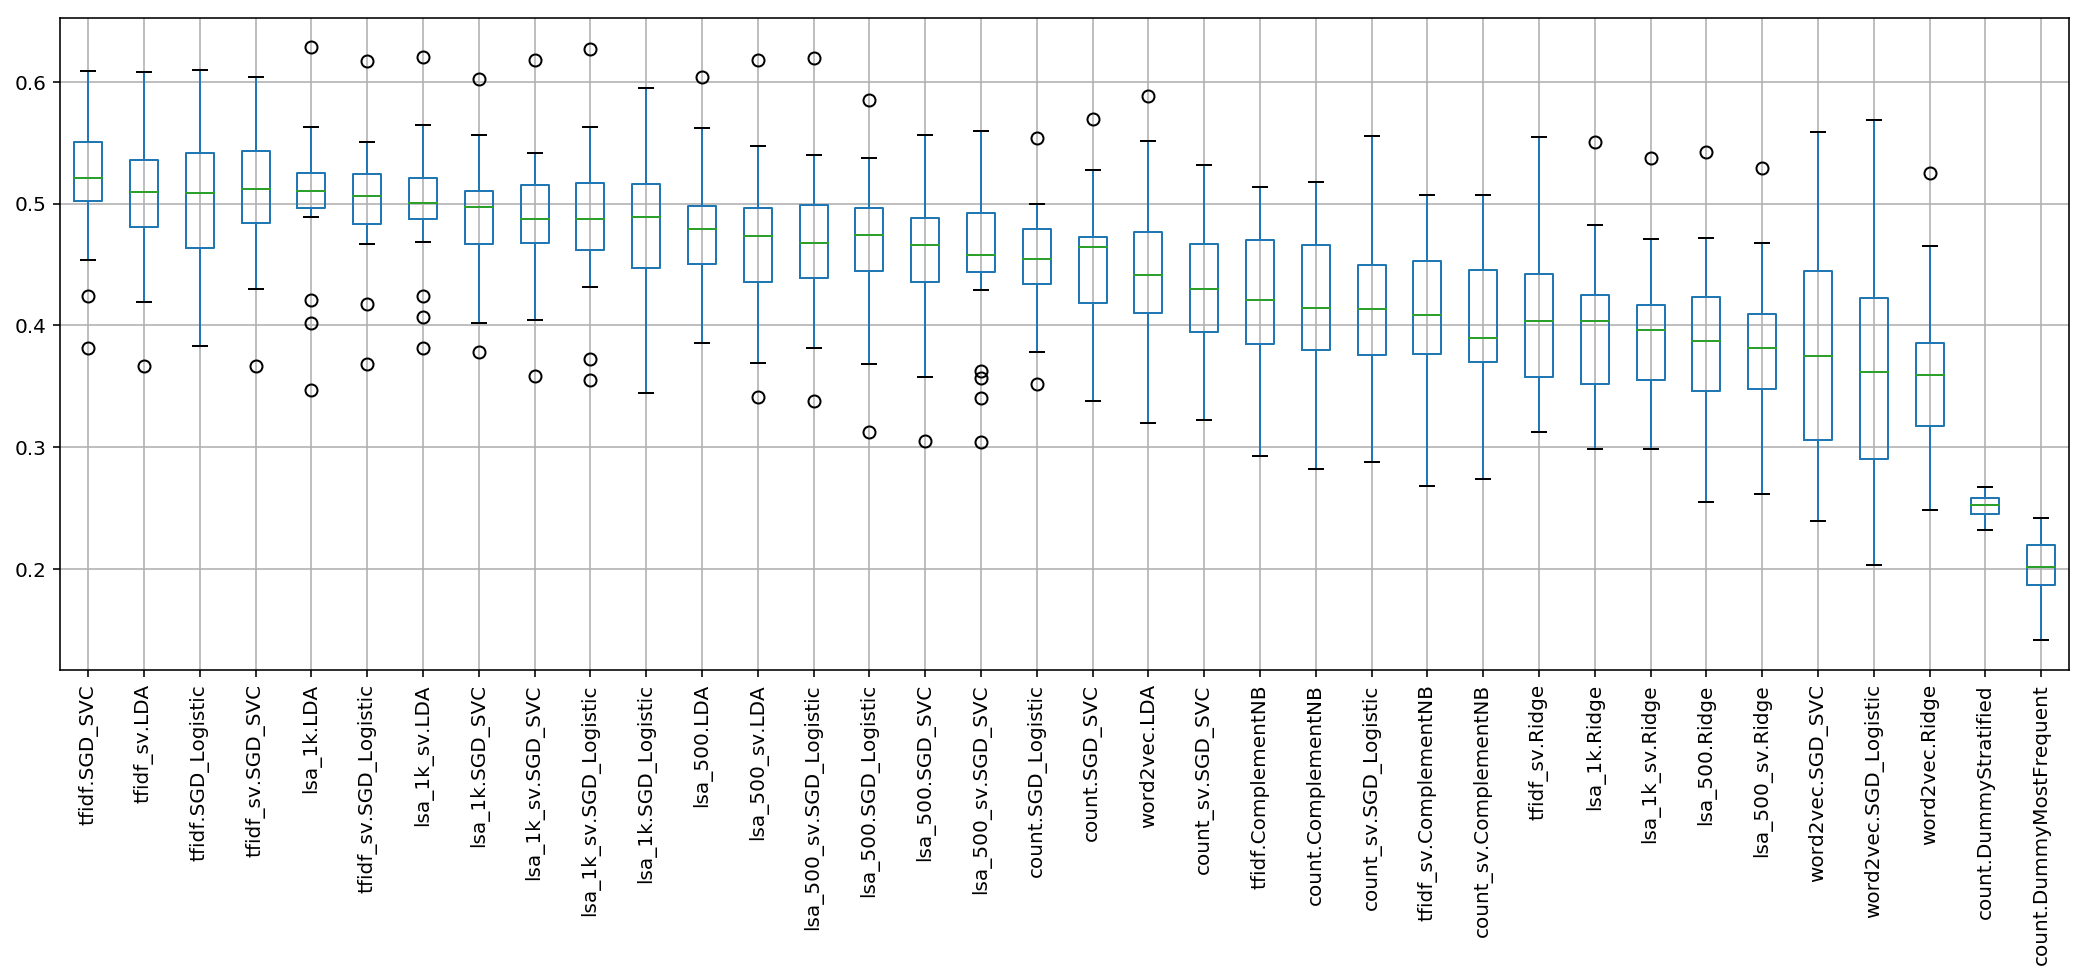

In [32]:
import matplotlib.pyplot as plt

df_test.drop([
    'tfidf.DummyStratified',
    'tfidf.DummyMostFrequent',
    'tfidf_sv.DummyStratified',
    'tfidf_sv.DummyMostFrequent',
    'count_sv.DummyStratified',
    'count_sv.DummyMostFrequent',
]).T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [33]:
results = conf['results']

In [34]:
from fgclassifier.utils import save_model

def clear_cache(model):
    if hasattr(model, 'steps'):
        for (name, step) in model.steps:
            clear_cache(step)
    if hasattr(model, 'cache'):
        model.cache = None
    return model

for name, model in results['models'].items():
    # skip unimportant models
    if 'QDA' in name:
        continue
    clear_cache(model)
    save_model(model)

clear_output()

In [46]:
x = results['models']['lsa_500_sv_SGD_SVC'].named_steps.lsa_500_sv.named_steps.tfidf_sv
display(x.cache)
x = x.named_steps.tfidf_sv
x.idf_.shape

None

(2000,)

In [40]:
x = results['models']['lsa_500_sv_SGD_SVC'].named_steps.lsa_500_sv.named_steps.lsa_500_sv
x.components_.shape

(500, 2000)

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [ ]:
# model = results['models']['lsa_500_en_LDA']
# print(X_test[0:1].shape)
# probas = model.predict_proba(X_test[0:1])
# probas[0].shape

In [ ]:
# model.predict(X_test[0:1])